# Analysis of sci-fate dataset

Here you will learn how to analyze a one-shot dataset from sci-fate using the CSP model with steady-state assumptions (CSPss) and comparing it to Dynamo method.

In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

import dynamo as dyn

## Load and preprocess the data

In [2]:
filename = './data/sci-fate/adata_sci_fate_A549.h5ad'
adata_sci_fate_A549 = dyn.read_h5ad(filename)

adata_sci_fate_A549.obs['time'] = 2
dyn_adata = adata_sci_fate_A549.copy()
dyn.pp.recipe_monocle(dyn_adata, tkey='time', keep_filtered_genes=False)
dyn.pp.cell_cycle_scores(dyn_adata, gene_list=None, refine=True, threshold=0.3)

|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----? 
Dynamo detects your labeling data is from a one-shot experiment, please correct 
this via supplying the correct experiment_type (one of `one-shot`, `kin`, `deg`) as needed

Select genes related to glucocorticoid receptor (GR) activation and cell cycle.

In [3]:
GR_genes = ["CEBPB", "FOXO1", "GTF2IRD1", "BCL6", "RARB", "THRA", "JUNB"]  # YOD1
cell_cycle_genes = ["E2F2", "E2F7", "E2F8", "MYBL2", "FOXML1", "EZH2", "BRCA1"]

In [4]:
# Supplementary Table 1: Differentially expressed (DE) genes between 0 hour and 2 hour DEX timepoints.
# Supplementary Table 2: Links between 27 TFs and 986 putatively regulated genes.
# Supplementary Table 3: Gene degradation rate in each 2 hour time window estimated by sci-fate.
si_table_0 = pd.read_excel('./data/sci-fate/table_SI.xlsx', sheet_name=0)
si_table_1 = pd.read_excel('./data/sci-fate/table_SI.xlsx', sheet_name=1)
si_table_2 = pd.read_excel('./data/sci-fate/table_SI.xlsx', sheet_name=2)

In [5]:
tmp = si_table_1.linked_gene.values[
    np.logical_and(si_table_1.TF.isin(GR_genes), si_table_1.correlation_coefficient_from_LASSO > 0.04)].tolist()
tmp.extend(GR_genes)
GR = adata_sci_fate_A549[:, adata_sci_fate_A549.var.gene_short_name.isin(tmp)]
dyn.pp.recipe_monocle(GR, n_top_genes=len(tmp), num_dim=25, tkey='time')

tmp_cell_cycle_genes = si_table_1.linked_gene.values[si_table_1.TF.isin(cell_cycle_genes)].tolist()
tmp_cell_cycle_genes.extend(cell_cycle_genes)
cell_cycle = adata_sci_fate_A549[:, adata_sci_fate_A549.var.gene_short_name.isin(tmp_cell_cycle_genes)]
dyn.pp.recipe_monocle(cell_cycle, n_top_genes=len(tmp_cell_cycle_genes), num_dim=6, tkey='time')

tmp_cell_cycle_genes.extend(tmp)

|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----? 
Dynamo detects your labelin

In [6]:
GR_cell_cycle = adata_sci_fate_A549[:, adata_sci_fate_A549.var.gene_short_name.isin(tmp_cell_cycle_genes)]
GR_cell_cycle.obs['time'] = 2
dyn.pp.recipe_monocle(GR_cell_cycle, n_top_genes=len(tmp_cell_cycle_genes), num_dim=25,
                      tkey='time', experiment_type='one-shot', total_layers=False,
                      keep_raw_layers=True)  # , min_counts=15, min_counts_u=10, n_top_genes=2500 n_top_genes can be tuned

|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----> detected experiment type: one-shot
|-----------> <insert> tkey to uns['pp'] in AnnData Object.
|-----------> <insert> experiment_type to uns['pp'] in AnnData Object

<Figure size 600x400 with 0 Axes>

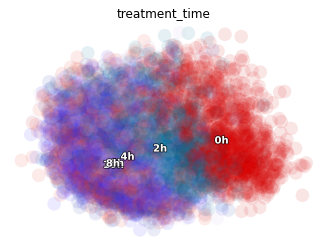

<Figure size 600x400 with 0 Axes>

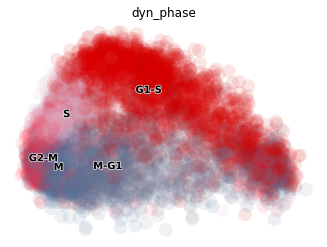

In [7]:
GR_cell_cycle.obs['dyn_phase'] = dyn_adata[GR_cell_cycle.obs_names, :].obs.cell_cycle_phase
GR_pca = GR.obsm['X_pca']
cell_cycle_pca = cell_cycle.obsm['X_pca']
GR_cell_cycle.obsm['X_pca'] = np.hstack((GR_pca[:, :2], cell_cycle_pca[:, :2]))
dyn.pl.pca(GR_cell_cycle, x=0, y=1, color='treatment_time')
dyn.pl.pca(GR_cell_cycle, x=2, y=3, color='dyn_phase')

## Use CSPss and Dynamo methods to infer parameters and calculate total velocity, respectively.

In [8]:
GR_cell_cycle_CSPss = GR_cell_cycle.copy()
GR_cell_cycle_Dynamo = GR_cell_cycle.copy()
del GR_cell_cycle

In [9]:
# for CSP with steady state
GR_cell_cycle_CSPss.uns["pp"]["experiment_type"] = 'kin'
dyn.tl.dynamics(GR_cell_cycle_CSPss,
                 model='deterministic',
                 tkey='time',
                 est_method='CSP4ML_CSPss')

dyn.tl.reduceDimension(GR_cell_cycle_CSPss, n_components=3, enforce=True)
dyn.tl.cell_velocities(GR_cell_cycle_CSPss, basis='pca')
dyn.tl.cell_velocities(GR_cell_cycle_CSPss, basis='umap', enforce=True)

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [197.2666s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.
|-----> experiment type: kin, method: CSP4ML_CSPss, model: deterministic


Estimate gamma via linear regression of t vs. -ln(1-K): 301it [00:00, 1028.44it/s]
Infer parameters via maximum likelihood estimation based on the CSP model under the steady-state assumption: 301it [00:00, 1119.25it/s]


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [20.1529s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity values.
|--

AnnData object with n_obs × n_vars = 7404 × 301
    obs: 'all_exon', 'all_intron', 'all_reads', 'treatment_time', 'doublet_score', 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'ntr', 'cell_cycle_phase', 'dyn_phase'
    var: 'gene_type', 'gene_short_name', 'nCells', 'nCounts', 'pass_basic_filter', 'use_for_pca', 'frac', 'ntr', 'alpha', 'a', 'b', 'alpha_a', 'alpha_i', 'beta', 'p_half_life', 'gamma', 'half_life', 'cost', 'logLL', 'gamma_k', 'gamma_r2', 'gamma_r2_raw', 'prob_off', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_genes', 'treatment_time_colors', 'dyn_phase_colors', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_pca', 'grid_velocity_umap'
    obsm: 'X_pca', 'X', 'cell_cycle_scores', 'X_umap', 'velocity_pca', 'velocity_umap'
    layer

In [10]:
# for Dynamo
dyn.tl.dynamics(GR_cell_cycle_Dynamo,
                model='deterministic',
                tkey='time',
               )
dyn.tl.reduceDimension(GR_cell_cycle_Dynamo, n_components=3, enforce=True)
dyn.tl.cell_velocities(GR_cell_cycle_Dynamo, basis='pca')
dyn.tl.cell_velocities(GR_cell_cycle_Dynamo, basis='umap', enforce=True)

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [13.9506s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.


estimating gamma: 100%|███████████████████████| 301/301 [00:07<00:00, 42.41it/s]


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [19.4196s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity values.
|--

AnnData object with n_obs × n_vars = 7404 × 301
    obs: 'all_exon', 'all_intron', 'all_reads', 'treatment_time', 'doublet_score', 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'ntr', 'cell_cycle_phase', 'dyn_phase'
    var: 'gene_type', 'gene_short_name', 'nCells', 'nCounts', 'pass_basic_filter', 'use_for_pca', 'frac', 'ntr', 'alpha', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'beta_k', 'gamma_k', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_genes', 'treatment_time_colors', 'dyn_phase_colors', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_pca', 'grid_velocity_umap'
    obsm: 'X_pca', 'X', 'cell_cycle_scores',

## Visualization

Change the settings for better visualization:

In [11]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
sc.set_figure_params(scanpy=True, fontsize=6)
figsize = (3, 3)
dpi = 600
path = './one-shot/streamline/'

### Streamline plots of one-shot labeling dataset from reveal two orthogonal processes of GR response and cell-cycle progression.

We plot streamline on the first two principal components (PCs), the second two PCs, and the first two UMAP components that are reduced from the four PCs, respectively.

<Figure size 300x300 with 0 Axes>

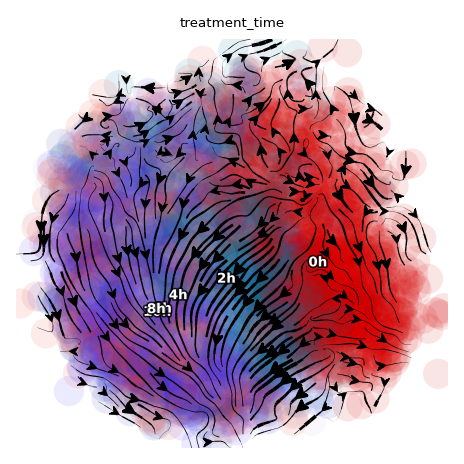

<Figure size 300x300 with 0 Axes>

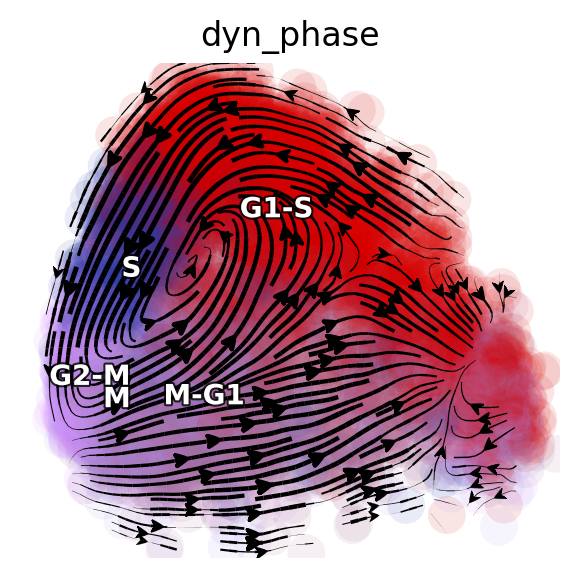

<Figure size 300x300 with 0 Axes>

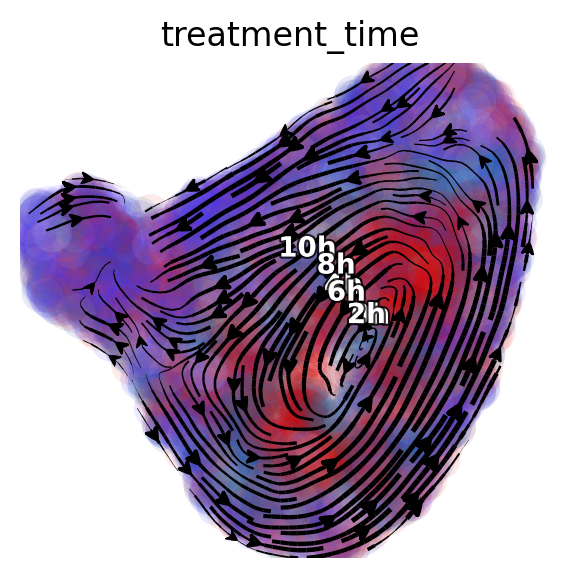

In [12]:
# CSP with steady-state
dyn.pl.streamline_plot(GR_cell_cycle_CSPss, x=0, y=1, color=['treatment_time'], basis='pca', show_legend='on data',
                       show_arrowed_spines=False, save_show_or_return='show', figsize=figsize,
                       save_kwargs={'prefix': 'GR_cell_cycle_0_1_pca_cspss', 'ext': 'png', 
                                    "bbox_inches": None, 'dpi': dpi, 'path': path}
                       )

dyn.pl.streamline_plot(GR_cell_cycle_CSPss, x=2, y=3, color=['dyn_phase'], basis='pca', show_legend='on data',
                       show_arrowed_spines=False, save_show_or_return='show', figsize=figsize,
                       save_kwargs={'prefix': 'GR_cell_cycle_2_3_pca_cspss', 'ext': 'png',
                                    "bbox_inches": None, 'dpi': dpi, 'path': path},
                       )

dyn.pl.streamline_plot(GR_cell_cycle_CSPss, x=0, y=1, color=['treatment_time'], basis='umap', show_legend='on data',
                       show_arrowed_spines=False, save_show_or_return='show', figsize=figsize,
                       save_kwargs={'prefix': 'GR_cell_cycle_0_1_umap_cspss', 'ext': 'png',
                                    "bbox_inches": None, 'dpi': dpi, 'path': path}
                       )

<Figure size 300x300 with 0 Axes>

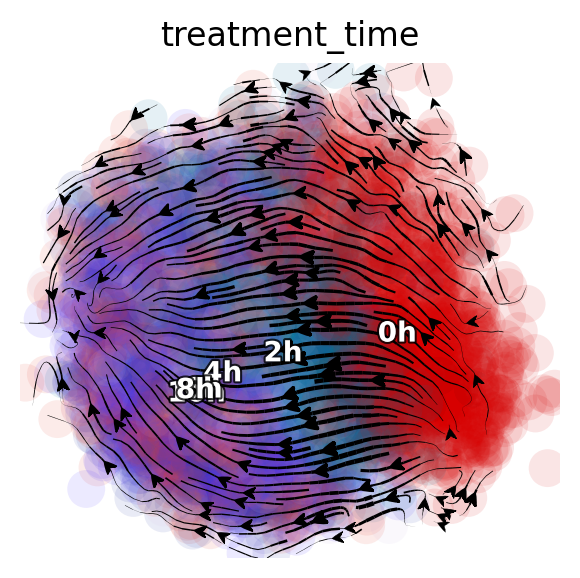

<Figure size 300x300 with 0 Axes>

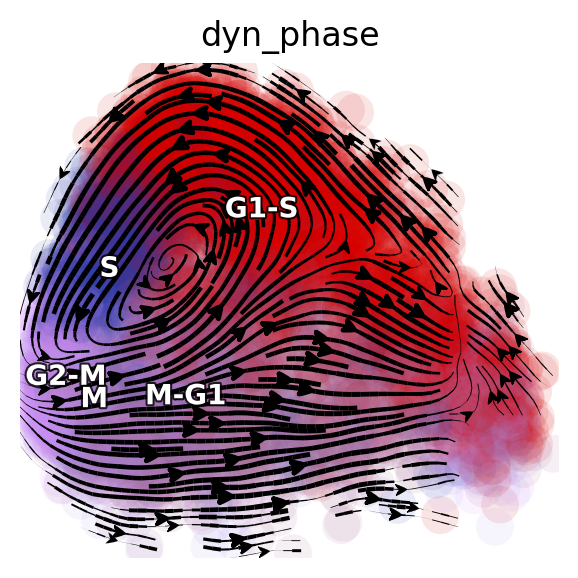

<Figure size 300x300 with 0 Axes>

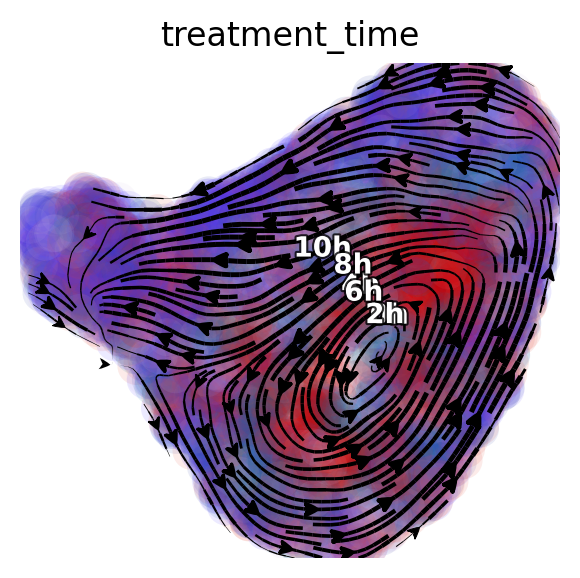

In [13]:
# Dynamo
dyn.pl.streamline_plot(GR_cell_cycle_Dynamo, x=0, y=1, color=['treatment_time'], basis='pca', show_legend='on data',
                       show_arrowed_spines=False, save_show_or_return='show', figsize=figsize,
                       save_kwargs={'prefix': 'GR_cell_cycle_0_1_pca_dynamo', 'ext': 'png',
                                    "bbox_inches": None, 'dpi': dpi, 'path': path}
                       )

dyn.pl.streamline_plot(GR_cell_cycle_Dynamo, x=2, y=3, color=['dyn_phase'], basis='pca', show_legend='on data',
                       show_arrowed_spines=False, save_show_or_return='show', figsize=figsize,
                       save_kwargs={'prefix': 'GR_cell_cycle_2_3_pca_dynamo', 'ext': 'png',
                                    "bbox_inches": None, 'dpi': dpi, 'path': path},
                       )

dyn.pl.streamline_plot(GR_cell_cycle_Dynamo, x=0, y=1, color=['treatment_time'], basis='umap', show_legend='on data',
                       show_arrowed_spines=False, save_show_or_return='show', figsize=figsize,
                       save_kwargs={'prefix': 'GR_cell_cycle_0_1_umap_dynamo', 'ext': 'png',
                                    "bbox_inches": None, 'dpi': dpi, 'path': path}
                       )

### Plot the inferred results of $\gamma_{t}$ of the two methods

In [14]:
gamma_CSPss = GR_cell_cycle_CSPss.var['gamma'].values
gamma_Dynamo = GR_cell_cycle_Dynamo.var['gamma'].values

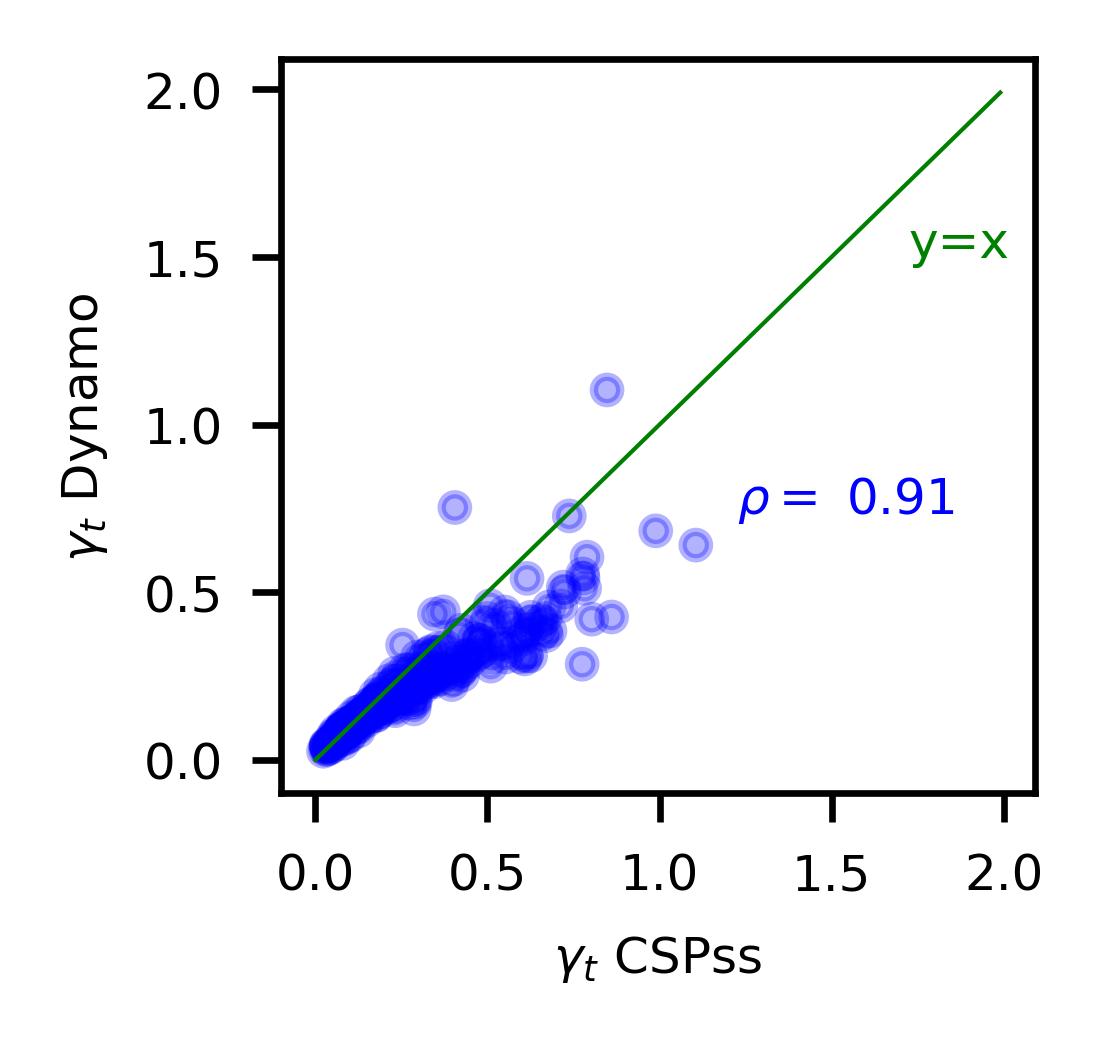

In [15]:
sc.set_figure_params(scanpy=True, fontsize=6)
scatter_size = 10
figsize = (1.61, 1.61)
alpha = 0.3
dpi = 300

gamma_CSPss = gamma_CSPss.astype('float')
gamma_Dynamo = gamma_Dynamo.astype('float')


range_min = 0
range_max = 2
x = np.arange(range_min, range_max, 0.01)
y = x

index_no_nan = np.logical_and(np.isfinite(gamma_CSPss), np.isfinite(gamma_Dynamo))
# correlation coefficient between all the genes
rho = np.corrcoef(gamma_CSPss[index_no_nan], gamma_Dynamo[index_no_nan])


fig = plt.figure(1, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
ax.scatter(gamma_CSPss, gamma_Dynamo, color='blue', s=scatter_size * np.ones(len(gamma_CSPss)), alpha=alpha)
ax.plot(x, y, color='g', linewidth=0.5, label='y=x')
plt.text(0.9, 0.75, 'y=x', ha='center', va='center', transform=ax.transAxes, color='g')
plt.text(0.75, 0.4, '$\\rho=$ %4.2f' % rho[0][1], 
         ha='center', va='center', transform=ax.transAxes, color='b')
plt.xlabel('$\gamma_t$ CSPss')
plt.ylabel('$\gamma_t$ Dynamo')
plt.grid(False)
# plt.savefig('./one-shot/comp/GR_cell_cycle.pdf',dpi=dpi, bbox_inches="tight")
plt.show()